<a href="https://colab.research.google.com/github/Carine-69/intro_to_ML_summative/blob/main/plant_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Plant diseases represent a major threat to global food security, contributing to significant agricultural losses annually. Conventional disease diagnosis relies on manual inspection by experts, which is labor-intensive, subjective, and prone to error. To address this, the integration of machine learning (ML) and computer vision provides an automated and scalable approach to early plant disease detection.

In [2]:
#importing libraries
# Core libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import cv2
from tqdm import tqdm

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Image processing
from skimage.io import imread
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [4]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = '/content/drive/MyDrive/ML-Datasets/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
# List the contents of the directory
print(os.listdir(data))

['valid', 'train']


In [ ]:
  # reading and resizing images
IMAGE_SIZE = (224, 224)

def load_flat_data(folder, max_per_class=None):
    X, Y = [], []
    class_names = [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]

    for class_name in tqdm(class_names, desc="Loading classes"):
        class_path = os.path.join(folder, class_name)
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if max_per_class:
            images = images[:max_per_class]
        for fname in images:
            path = os.path.join(class_path, fname)
            try:
                img = cv2.imread(path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_resized = cv2.resize(img, IMAGE_SIZE)
                X.append(img_resized.flatten())
                Y.append(class_name)
            except Exception as e:
                print(f"Skipping {path}: {e}")
                continue
    return np.array(X), np.array(Y)


In [ ]:
#preprocess the data for model use

data = '/content/drive/MyDrive/ML-Datasets/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'

X_train, Y_train = load_flat_data(os.path.join(data, 'train'), max_per_class=200)
X_val, Y_val = load_flat_data(os.path.join(data, 'valid'), max_per_class=50)

print(" Train shape:", X_train.shape)
print(" Validation shape:", X_val.shape)

save_path = '/content/drive/MyDrive/ML-Datasets/processed_data'

X_train = np.load(os.path.join(save_path, 'X_train.npy'), allow_pickle=True)
Y_train = np.load(os.path.join(save_path, 'Y_train.npy'), allow_pickle=True)
X_val = np.load(os.path.join(save_path, 'X_val.npy'), allow_pickle=True)
Y_val = np.load(os.path.join(save_path, 'Y_val.npy'), allow_pickle=True)

print(" Data loaded successfully!")
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)


In [5]:
# PATHS TO PREPROCESSED DATA
save_path = '/content/drive/MyDrive/ML-Datasets/processed_data'

# LOAD DATA
X_train = np.load(os.path.join(save_path, 'X_train.npy'), allow_pickle=True)
Y_train = np.load(os.path.join(save_path, 'Y_train.npy'), allow_pickle=True)
X_val = np.load(os.path.join(save_path, 'X_val.npy'), allow_pickle=True)
Y_val = np.load(os.path.join(save_path, 'Y_val.npy'), allow_pickle=True)

print("Shapes:")
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_val:", X_val.shape)
print("Y_val:", Y_val.shape)

Shapes:
X_train: (7600, 150528)
Y_train: (7600,)
X_val: (1900, 150528)
Y_val: (1900,)


In [6]:
#  PREPROCESSING
#  reshape flattened images back to images
if len(X_train.shape) == 2:
    X_train_img = X_train.reshape(-1, 224, 224, 3)
    X_val_img = X_val.reshape(-1, 224, 224, 3)
else:
    X_train_img = X_train
    X_val_img = X_val

# Resize to smaller for traditional ML
IMG_SIZE = 112
X_train_small = np.array([cv2.resize(img, (IMG_SIZE, IMG_SIZE)) for img in X_train_img])
X_val_small = np.array([cv2.resize(img, (IMG_SIZE, IMG_SIZE)) for img in X_val_img])

# Normalize to [0,1]
X_train_small = X_train_small / 255.0
X_val_small = X_val_small / 255.0

# Flatten for traditional ML
X_train_flat = X_train_small.reshape(len(X_train_small), -1)
X_val_flat = X_val_small.reshape(len(X_val_small), -1)

print("Flattened shapes for traditional ML:")
print(X_train_flat.shape, X_val_flat.shape)

Flattened shapes for traditional ML:
(7600, 37632) (1900, 37632)


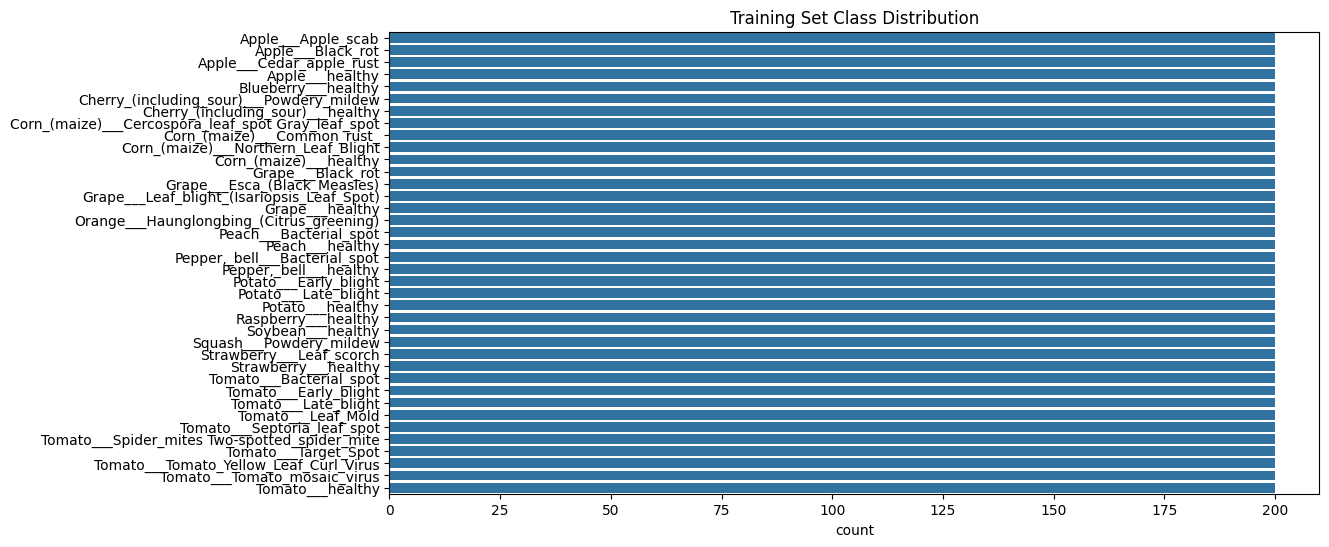

In [7]:
# Encoding  labels
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
le = LabelEncoder()
Y_train_enc = le.fit_transform(Y_train)
Y_val_enc = le.transform(Y_val)
num_classes = len(np.unique(Y_train_enc))

# Visualize class distribution
plt.figure(figsize=(12,6))
sns.countplot(y=Y_train, order=pd.Series(Y_train).value_counts().index)
plt.title("Training Set Class Distribution")
plt.show()

PCA shapes:
(7600, 300) (1900, 300)
Random Forest Accuracy: 0.5257894736842105
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.28      0.34        50
           1       0.39      0.30      0.34        50
           2       0.33      0.34      0.34        50
           3       0.43      0.46      0.45        50
           4       0.51      0.52      0.51        50
           5       0.55      0.52      0.54        50
           6       0.51      0.80      0.62        50
           7       0.65      0.40      0.49        50
           8       0.77      0.98      0.86        50
           9       0.47      0.66      0.55        50
          10       0.83      0.96      0.89        50
          11       0.40      0.58      0.48        50
          12       0.54      0.56      0.55        50
          13       0.61      0.90      0.73        50
          14       0.45      0.70      0.55        50
          15       0.60      0.8

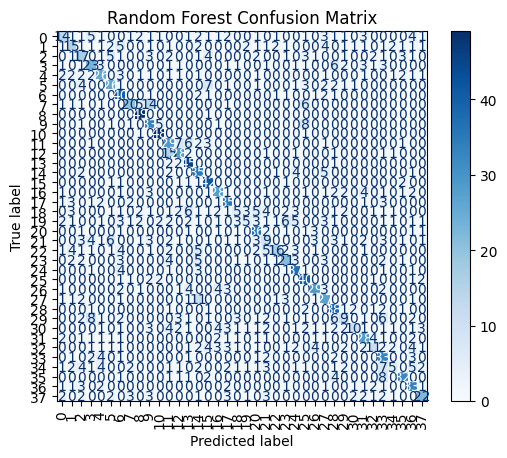

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression Accuracy: 0.52
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.42      0.41        50
           1       0.48      0.42      0.45        50
           2       0.42      0.32      0.36        50
           3       0.38      0.44      0.41        50
           4       0.41      0.50      0.45        50
           5       0.46      0.56      0.50        50
           6       0.69      0.68      0.69        50
           7       0.64      0.50      0.56        50
           8       0.90      0.88      0.89        50
           9       0.52      0.64      0.58        50
          10       0.87      0.92      0.89        50
          11       0.57      0.58      0.57        50
          12       0.71      0.64      0.67        50
          13       0.79      0.88      0.83        50
          14       0.59      0.70      0.64        50
          15       0.59      0.88      0.70        50
          16       0.4

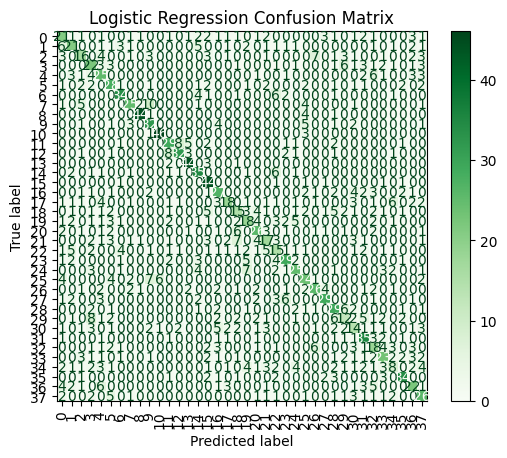

In [8]:
#  TRADITIONAL ML MODELS: RANDOM FOREST & LOGISTIC REGRESSION


# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)

#  PCA for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt

pca_components = 300
pca = PCA(n_components=pca_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

print("PCA shapes:")
print(X_train_pca.shape, X_val_pca.shape)

#  RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_pca, Y_train_enc)
Y_pred_rf = rf.predict(X_val_pca)

print("Random Forest Accuracy:", accuracy_score(Y_val_enc, Y_pred_rf))
print("Classification Report:\n", classification_report(Y_val_enc, Y_pred_rf))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(Y_val_enc, Y_pred_rf, xticks_rotation='vertical', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

#  LOGISTIC REGRESSION
logreg = LogisticRegression(max_iter=500, solver='saga', multi_class='multinomial', n_jobs=-1, C=0.5)
logreg.fit(X_train_pca, Y_train_enc)
Y_pred_log = logreg.predict(X_val_pca)

print("Logistic Regression Accuracy:", accuracy_score(Y_val_enc, Y_pred_log))
print("Classification Report:\n", classification_report(Y_val_enc, Y_pred_log))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(Y_val_enc, Y_pred_log, xticks_rotation='vertical', cmap='Greens')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

INTERPRATAION:                                       
1. Random forest: from the result, we see that the accuracy is 52.6 % meaning it couldn't learn complex visula patterns form images.

some classes like class 8 and 10 were very well predicted while others like 18,19,34 were poorly predicted indicating high variance between classes.

Random forest underfit.

2 Logistic regression:
The results were very similar to random forest with accuracy of 52% but worse due to underfitting everywhere.(most callses have low F10scores)

Being a linear model, logistic regression could not capture complex, non linear relationships between the images.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.0594 - loss: 3.5667 - val_accuracy: 0.2863 - val_loss: 2.7538
Epoch 2/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.2352 - loss: 2.7995 - val_accuracy: 0.4353 - val_loss: 2.1823
Epoch 3/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.3380 - loss: 2.3618 - val_accuracy: 0.5174 - val_loss: 1.8247
Epoch 4/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.4216 - loss: 2.0367 - val_accuracy: 0.5500 - val_loss: 1.6587
Epoch 5/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.4613 - loss: 1.8740 - val_accuracy: 0.6063 - val_loss: 1.4517
Epoch 6/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5045 - loss: 1.7005 - val_accuracy: 0.6347 - val_loss: 1.3509
Epoch 7/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5379 - loss: 1.5937 - val_accuracy: 0.6395 - val_loss: 1.2672
Epoch 8/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5750 - loss: 1.4551 - val_acc

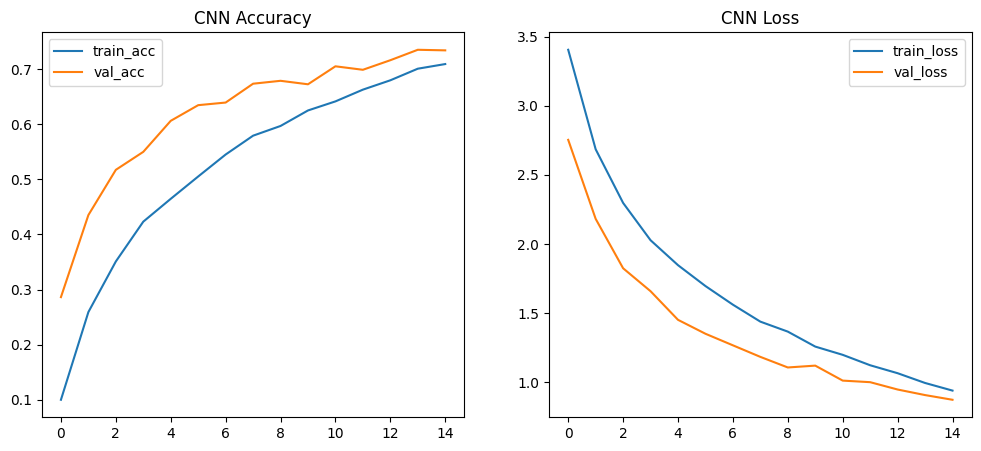

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


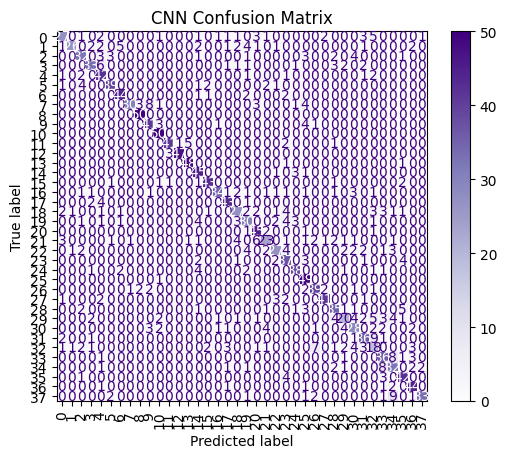

In [7]:

# 6. NEURAL NETWORK: CNN FROM SCRATCH

import numpy as np
import cv2
from sklearn.metrics import ConfusionMatrixDisplay

# Resize images for CNN
IMG_SIZE_CNN = 112
X_train_cnn = np.array([cv2.resize(img, (IMG_SIZE_CNN, IMG_SIZE_CNN)) for img in X_train_img]) / 255.0
X_val_cnn = np.array([cv2.resize(img, (IMG_SIZE_CNN, IMG_SIZE_CNN)) for img in X_val_img]) / 255.0

# Encode labels for CNN
from tensorflow.keras.utils import to_categorical
Y_train_cnn = to_categorical(Y_train_enc, num_classes)
Y_val_cnn = to_categorical(Y_val_enc, num_classes)

# Build  CNN
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE_CNN, IMG_SIZE_CNN,3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Early stopping to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train CNN
history_cnn = cnn_model.fit(X_train_cnn, Y_train_cnn,
                            validation_data=(X_val_cnn, Y_val_cnn),
                            epochs=15,
                            batch_size=32,
                            callbacks=[early_stop])

# Evaluate CNN
val_loss, val_acc = cnn_model.evaluate(X_val_cnn, Y_val_cnn)
print(f"CNN Validation Accuracy: {val_acc*100:.2f}%")

# Plot learning curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'], label='train_acc')
plt.plot(history_cnn.history['val_accuracy'], label='val_acc')
plt.title('CNN Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'], label='train_loss')
plt.plot(history_cnn.history['val_loss'], label='val_loss')
plt.title('CNN Loss')
plt.legend()
plt.show()

# Confusion Matrix
Y_val_pred_cnn = np.argmax(cnn_model.predict(X_val_cnn), axis=1)
ConfusionMatrixDisplay.from_predictions(Y_val_enc, Y_val_pred_cnn, xticks_rotation='vertical', cmap='Purples')
plt.title("CNN Confusion Matrix")
plt.show()

The accuracy of 73.4% of CNN is much better than that of traditional ML modelsbut some classes were predicted poorly.

Training accuracy grew steadly but validation accuracy stayed around 73-74% and loss curvewas smoth meaninn no major overfit.

In [8]:

# 7. TRANSFER LEARNING: RESNET50

import numpy as np
import cv2

# Parameters
IMG_SIZE_TL = 224
BATCH_SIZE = 8

# Resize images for ResNet50
X_train_tl = np.array([cv2.resize(img, (IMG_SIZE_TL, IMG_SIZE_TL)) for img in X_train_img])
X_val_tl = np.array([cv2.resize(img, (IMG_SIZE_TL, IMG_SIZE_TL)) for img in X_val_img])

# Encode labels as integers
Y_train_tl = Y_train_enc
Y_val_tl = Y_val_enc

# Preprocess images for ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
X_train_tl = preprocess_input(X_train_tl)
X_val_tl = preprocess_input(X_val_tl)

# Use ImageDataGenerator for batch processing
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train_tl, Y_train_tl, batch_size=BATCH_SIZE)
val_generator = val_datagen.flow(X_val_tl, Y_val_tl, batch_size=BATCH_SIZE)

# Load pretrained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(IMG_SIZE_TL, IMG_SIZE_TL, 3))
base_model.trainable = False

# Build classifier on top
tl_model = Sequential([
    base_model,
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

tl_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model
history_tl = tl_model.fit(train_generator,
                          validation_data=val_generator,
                          epochs=10,
                          callbacks=[early_stop])

# Evaluate
val_loss, val_acc = tl_model.evaluate(val_generator)
print(f"Transfer Learning Validation Accuracy: {val_acc*100:.2f}%")

# Confusion Matrix
Y_val_pred_tl = np.argmax(tl_model.predict(val_generator), axis=1)
ConfusionMatrixDisplay.from_predictions(Y_val_tl, Y_val_pred_tl, xticks_rotation='vertical', cmap='Oranges')
plt.title("Transfer Learning Confusion Matrix")
plt.show()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


950/950 ━━━━━━━━━━━━━━━━━━━━ 53s 40ms/step - accuracy: 0.5356 - loss: 1.7959 - val_accuracy: 0.8695 - val_loss: 0.3834
Epoch 2/10
950/950 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.8673 - loss: 0.4317 - val_accuracy: 0.9147 - val_loss: 0.3032
Epoch 3/10
950/950 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - accuracy: 0.8843 - loss: 0.3584 - val_accuracy: 0.9221 - val_loss: 0.2368
Epoch 4/10
950/950 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - accuracy: 0.9067 - loss: 0.2819 - val_accuracy: 0.9300 - val_loss: 0.1963
Epoch 5/10
950/950 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - accuracy: 0.9122 - loss: 0.2737 - val_accuracy: 0.9216 - val_loss: 0.2140
Epoch 6/10
950/950 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - accuracy: 0.9138 - loss: 0.2630 - val_accuracy: 0.9426 - val_loss: 0.1984
Epoch 7/10
950/950 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - accuracy: 0.9306 - loss: 0.2180 - val_accuracy: 0.9305 - val_loss: 0.2894
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9268 - loss: 0.1924
Transfer Learning Validat

NameError: name 'ConfusionMatrixDisplay' is not defined

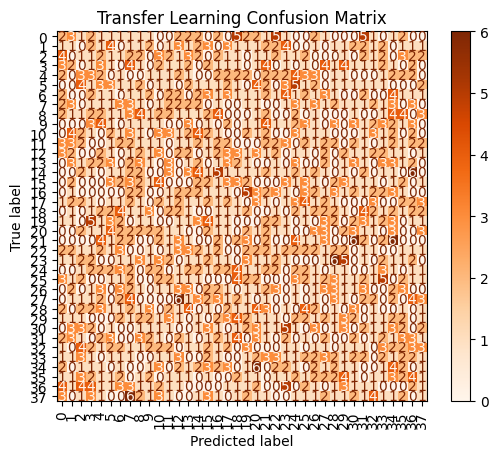

In [13]:

#correction of error
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(Y_val_tl, Y_val_pred_tl, xticks_rotation='vertical', cmap='Oranges')
plt.title("Transfer Learning Confusion Matrix")
plt.show()

Transfer learning performed best amom=ng other models with accuracy of 93%, accuracies of training and validation close and minor fluctuation in validation accuracy between epoch 4-7.

Pretrained ResNet50 feature fomr ImageNet captured texture, shapes, and patterns that helped classify complex images